In this first script the target othormosaics where we want to detect the seedlings are split into tiles so the deep learning model can work on them. For that, python and dependencies are intalled, the tile and buffer size are indicated and the tiling is carried out.

# 1. Split the target orthomosaic into tiles (data tiling)

The first step is to split the target orthomosaic into tiles that the deep learning model will work on.

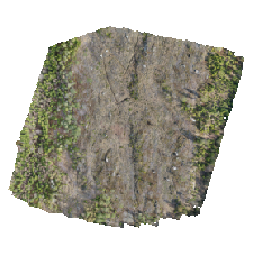 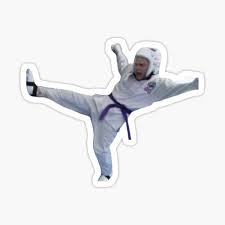

## 1.1 Define the input parameters

In [ ]:
# define path to your own google drive
my_drive_path="/content/drive/MyDrive/HOME_EXAM"
path_data=my_drive_path+"/NOVA_course_deep_learning/data"

input_ortho_path=path_data+"/orthomosaics/test_data" # this will be the drone mosaic # /galbyveien_20230504_sun.tif

In [ ]:
# tiling parameters
tile_size_m=10 # tile size in m
buffer_size_m=0 # tile buffer size_m (used to produce overlapping tiles)

## 1.2 Install dependencies

In [ ]:
# install required libraries (if running in a local conda environment then other libraries might need to be installed)
!pip install geopandas
!pip install rasterio
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 128.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 27.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# general python packages
## general packages
import os, glob, shutil
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# geospatial packages
from osgeo import gdal, ogr, osr
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
import folium

# define path to where osgeo utils (gdal_retile.py) are stored
path_osgeo_utils= "/usr/local/lib/python3.10/dist-packages/osgeo_utils"

### 1.2 Mount google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# check what is in your google drive
!ls "/content/drive/My Drive/HOME_EXAM"

annotated_data	map_data  orthomosaics	tiles


### 1.3 Load data

In [ ]:
path_data=my_drive_path+"/"
orthos = os.listdir(path_data+"orthomosaics/test_data")

#all_flights_path="S:/Prosjekter/52106_SFI_SmartForest/annotated_datasets/SemanticSegmentation_windDamage/orthomosaics/allFlights_boundary.shp"
#all_flights = gpd.read_file(all_flights_path)

#all_flights.head()

In [ ]:
orthos

['krakstad_202304_sun.tif',
 'ortho_hobol_042222_mavic_sun.tif',
 'braatan_40m_20230605_sun.tif',
 'galbyveien_20230504_sun.tif']

### Load orthomosaic footprints (pre-create vector file)

In [ ]:
# define directory to where the drone acquisition geojson is stored
dir_drone_acquisitions=path_data+"/map_data/drone_acquisitions.geojson"
dir_drone_acquisitions
footprints= gpd.read_file(dir_drone_acquisitions)

## 1.4 Tiling

In [ ]:
d = path_data+"orthomosaics/test_data"
for path in os.listdir(d):
    orthos = os.path.join(d, path)
    
    # get orthomosaic name
    ortho_name=os.path.splitext(os.path.basename(orthos)) [0]

    # Define and create an output directory to store the tiles
    output_tiles_dir=path_data+"/tiles/"+str(tile_size_m)+"m_"+ortho_name
    if not os.path.exists(output_tiles_dir):
      os.makedirs(output_tiles_dir)  
    print(output_tiles_dir)

    # Get pixel resolution (in meters) and tile size in pixels
    src_ds = gdal.Open(orthos) # reads in the orthomosaic
    _, xres, _, _, _, yres  = src_ds.GetGeoTransform() # get pixel size in meters
    print("Ortho resolution: "+str(round(xres,4))+" m")

    # Get EPSG code
    proj = osr.SpatialReference(wkt=src_ds.GetProjection())
    EPSG_code= proj.GetAttrValue('AUTHORITY',1)
    print("EPSG code: "+str(EPSG_code))

    # get number of bands
    n_bands=src_ds.RasterCount
    print("Number of bands: "+str(n_bands))

    # Do the actual tiling
    # Compute tile and buffer size in pixels
    tile_size_px= round(tile_size_m/abs(xres)) # calculate the tile size in pixels
    buffer_size_px= round(buffer_size_m/abs(xres)) # calculate the buffer size in pixels
    print("The tile size in pixels is: "+str(tile_size_px))
    print("The size of the overalp between tiles in pixels is: "+str(buffer_size_px))

    # define name for output tile index shapefile
    tileIndex_name=ortho_name+"_tile_index"

    # Run gdal_retile.py using CLI (can take some minutes) 
    command_retile = "python "+path_osgeo_utils+"/gdal_retile.py -targetDir " + output_tiles_dir + " " + orthos+ " -overlap " + str(buffer_size_px) + " -ps "+str(tile_size_px) + " " + str(tile_size_px) + " -of GTiff -tileIndex "+ tileIndex_name + " -tileIndexField ID"
    print(os.popen(command_retile).read()) 

    footprints= gpd.read_file(dir_drone_acquisitions)
    footprint_ortho= footprints[footprints['filename']==ortho_name]
    footprint_ortho_UU= footprint_ortho.geometry.unary_union

    # Load tiles shapefile
    tiles = gpd.read_file(output_tiles_dir+ "/"+ortho_name+"_tile_index.shp")
    tiles= tiles.to_crs(EPSG_code)

    # Select all tiles that are within the boundary polygon
    tiles_in = tiles[tiles.geometry.within(footprint_ortho_UU)]

    # Select all tiles that are not within the boundary polygon
    tiles_out= tiles.loc[~tiles['ID'].isin(tiles_in['ID']) ]
    print(str(len(tiles_out))+" tiles to be deleted")
    print(str(len(tiles_in))+" tiles remaining")


    # delete tiles that are not within the footprint
    gtiffs_delete=[output_tiles_dir+ "/"+sub  for sub in tiles_out['ID']] 
    for f in gtiffs_delete:
      if os.path.exists(f):
        os.remove(f)
    

/content/drive/MyDrive/HOME_EXAM//tiles/10m_krakstad_202304_sun
Ortho resolution: 0.0077 m
EPSG code: 25832
Number of bands: 4
The tile size in pixels is: 1297
The size of the overalp between tiles in pixels is: 0


0...10...20...30...40...50...60...70...80...90...100 - done.

283 tiles to be deleted
177 tiles remaining
/content/drive/MyDrive/HOME_EXAM//tiles/10m_ortho_hobol_042222_mavic_sun
Ortho resolution: 0.0074 m
EPSG code: 25832
Number of bands: 4
The tile size in pixels is: 1358
The size of the overalp between tiles in pixels is: 0


0...10...20...30...40...50...60...70...80...90...100 - done.

194 tiles to be deleted
158 tiles remaining
/content/drive/MyDrive/HOME_EXAM//tiles/10m_braatan_40m_20230605_sun
Ortho resolution: 0.0085 m
EPSG code: 25832
Number of bands: 4
The tile size in pixels is: 1177
The size of the overalp between tiles in pixels is: 0


0...10...20...30...40...50...60...70...80...90...100 - done.

903 tiles to be deleted
337 tiles remaining
/content/drive/MyDrive/HOME_EXAM//tiles/10m_galbyveien_20230504_sun
Ortho resolution: 0.0108 m
EPSG code: 25832
Number of bands: 4
The tile size in pixels is: 926
The size of the overalp between tiles in pixels is: 0


0...10...20...30...40...50...60...70...80...90...100 - done.

714 tiles to be deleted
470 tiles remaining


In [ ]:
footprints.explore()

In [ ]:
field_data = gpd.read_file(path_data+ "map_data/test_annotations2_sun.geojson")

In [ ]:
field_data.explore(color = "green")
# footprints.explore()

Output hidden; open in https://colab.research.google.com to view.